# Bedrock Claude Prompt Engineering exercises (multi_model)
reference: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-claude.html


#### Lesson			
The following examples show how to pass an image and prompt text in a multimodal message to an Anthropic Claude 3 Sonnet model.		
			

In [1]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

  Using cached boto3-1.34.84-py3-none-any.whl.metadata (6.6 kB)
  Using cached awscli-1.32.84-py3-none-any.whl.metadata (11 kB)
  Using cached botocore-1.34.84-py3-none-any.whl.metadata (5.7 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl.metadata (14 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached pyasn1-0.6.0-py2.py3-none-any.whl.metadata (8.3 kB)
Using cached boto3-1.34.84-py3-none-any.whl (139 kB)
Using cached awscli-1.32.84-py3-none-any.whl (4.4 MB)
Using cached botoco

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aws-langchain 0.0.1 requires langchain==0.0.137, but you have langchain 0.0.309 which is incompatible.
streamlit 1.25.0 requires pillow<10,>=7.1.0, but you have pillow 10.0.0 which is incompatible.
wasabi 1.1.2 requires colorama>=0.4.6; sys_platform == "win32" and python_version >= "3.7", but you have colorama 0.4.4 which is incompatible.


This notebook demonstrates invoking Bedrock models directly using the AWS SDK, but for later notebooks in the workshop you'll also need to install [LangChain](https://github.com/hwchase17/langchain):

In [2]:
%pip install --quiet langchain==0.0.309

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install termcolor --quiet

Note: you may need to restart the kernel to use updated packages.


---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=bedrock_runtime`

In [4]:
import boto3
import json 
from termcolor import colored  

bedrock = boto3.client(service_name="bedrock", region_name="us-west-2")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [5]:
response = bedrock.list_foundation_models()
# Filter models with modelArn containing "claude"
filtered_models = [model for model in response['modelSummaries'] if 'claude' in model['modelArn'] ]

# Print the filtered models
for model in filtered_models:
    print("Model Name:", model['modelName'])
    print("Model ARN:", model['modelArn'])
    print("Provider Name:", model['providerName'])
    print()




Model Name: Claude Instant
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-instant-v1:2:100k
Provider Name: Anthropic

Model Name: Claude Instant
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-instant-v1
Provider Name: Anthropic

Model Name: Claude
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-v2:0:18k
Provider Name: Anthropic

Model Name: Claude
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-v2:0:100k
Provider Name: Anthropic

Model Name: Claude
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-v2:1:18k
Provider Name: Anthropic

Model Name: Claude
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-v2:1:200k
Provider Name: Anthropic

Model Name: Claude
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-v2:1
Provider Name: Anthropic

Model Name: Claude
Model ARN: arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-v2

---

## Common inference parameter definitions

### Randomness and Diversity

Foundation models support the following parameters to control randomness and diversity in the 
response.

**Temperature** – Large language models use probability to construct the words in a sequence. For any 
given next word, there is a probability distribution of options for the next word in the sequence. When 
you set the temperature closer to zero, the model tends to select the higher-probability words. When 
you set the temperature further away from zero, the model may select a lower-probability word.

In technical terms, the temperature modulates the probability density function for the next tokens, 
implementing the temperature sampling technique. This parameter can deepen or flatten the density 
function curve. A lower value results in a steeper curve with more deterministic responses, and a higher 
value results in a flatter curve with more random responses.

**Top K** – Temperature defines the probability distribution of potential words, and Top K defines the cut 
off where the model no longer selects the words. For example, if K=50, the model selects from 50 of the 
most probable words that could be next in a given sequence. This reduces the probability that an unusual 
word gets selected next in a sequence.
In technical terms, Top K is the number of the highest-probability vocabulary tokens to keep for Top-
K-filtering - This limits the distribution of probable tokens, so the model chooses one of the highest-
probability tokens.

**Top P** – Top P defines a cut off based on the sum of probabilities of the potential choices. If you set Top 
P below 1.0, the model considers the most probable options and ignores less probable ones. Top P is 
similar to Top K, but instead of capping the number of choices, it caps choices based on the sum of their 
probabilities.
For the example prompt "I hear the hoof beats of ," you may want the model to provide "horses," 
"zebras" or "unicorns" as the next word. If you set the temperature to its maximum, without capping 
Top K or Top P, you increase the probability of getting unusual results such as "unicorns." If you set the 
temperature to 0, you increase the probability of "horses." If you set a high temperature and set Top K or 
Top P to the maximum, you increase the probability of "horses" or "zebras," and decrease the probability 
of "unicorns."

### Length

The following parameters control the length of the generated response.

**Response length** – Configures the minimum and maximum number of tokens to use in the generated 
response.

**Length penalty** – Length penalty optimizes the model to be more concise in its output by penalizing 
longer responses. Length penalty differs from response length as the response length is a hard cut off for 
the minimum or maximum response length.

In technical terms, the length penalty penalizes the model exponentially for lengthy responses. 0.0 
means no penalty. Set a value less than 0.0 for the model to generate longer sequences, or set a value 
greater than 0.0 for the model to produce shorter sequences.

### Repetitions

The following parameters help control repetition in the generated response.

**Repetition penalty (presence penalty)** – Prevents repetitions of the same words (tokens) in responses. 
1.0 means no penalty. Greater than 1.0 decreases repetition.

---

## Try out the models
good practices for prompting to perceive and analyze existing images:

Provide Clear Context: Give me context about the image you want me to analyze, such as its subject matter, purpose, or where it will be used. This helps me tailor my analysis appropriately.

Specify Analysis Type: Let me know what kind of analysis you need, such as describing the image contents, identifying objects/people, interpreting the artistic style, evaluating the composition, or detecting any issues/flaws.

Ask Specific Questions: In addition to a general analysis, you can ask me specific questions about the image, such as "What emotion does this portrait convey?", "How does the lighting affect the mood?", or "Does this product photo follow best practices?"

Provide Reference Images: If you have reference images to compare against, provide those as well. I can analyze the similarities, differences, and how well the image aligns with the references.

Share Image Details: Give me any available metadata about the image, such as the artist/creator, date, medium, dimensions, or context in which it was created.

Clarify Your Goals: Explain your goals or intended use for the image analysis, such as improving the image, using it for a specific purpose, or better understanding its meaning/impact.

Use Clear Image Uploads: Make sure to upload the image clearly, without obstructions or compression artifacts that could affect my perception.

Request Specific Outputs: Let me know if you need a particular output format for my analysis, such as a written description, a list of observations, or specific ratings/scores.

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:

### Anthropic Claude

# Multimodal prompt with InvokeModel

#### Lesson			
The following examples show how to pass an image and prompt text in a multimodal message to an Anthropic Claude 3 Sonnet model.			

In [6]:
import boto3
import json 

bedrock = boto3.client(service_name="bedrock", region_name="us-west-2")
bedrock_runtime = boto3.client(service_name="bedrock-runtime", region_name="us-west-2")

In [7]:
model ="anthropic.claude-3-sonnet-20240229-v1:0"

In [8]:
#model ="anthropic.claude-3-haiku-20240307-v1:0"

In [9]:
import botocore,time
import os
from pathlib import Path
import base64
accept = "application/json"
content_type = "application/json"

# Claude3
def get_multi_modal_completion (prompt: str, system_prompt="", prefill ="", image=""):
    modelId_3 = model

    if image:

        # Get the current working directory
        cwd = os.getcwd()
        #print(f"Current Working Directory: {cwd}")
        
        # Get the current Jupyter Notebook file path
        image_path = cwd +"\\image\\"+image
        print(f"Current Image Path: {image_path}")      
        # Read reference image from file and encode as base64 strings.
        with open(image_path, "rb") as image_file:
            content_image = base64.b64encode(image_file.read()).decode('utf8')

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "source": {"type": "base64",
                        "media_type": "image/jpeg", "data": content_image}}
                    ]
            }
        ]

    if prefill:
        messages.append(
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": prefill,
                    }
                ],
            }
        )

    
    body_3 = json.dumps(
    	{
    		"messages": messages,
    		"anthropic_version": "bedrock-2023-05-31",
    		"max_tokens": 1000,
            "system": system_prompt,
    		"temperature": 0,
    		"top_p": 0.9,
    	}
    )
    
    time_sta = time.perf_counter()
    response_3 = bedrock_runtime.invoke_model(
    	body=body_3, modelId=modelId_3, accept=accept, contentType=content_type
    )
   
    response_body_3 = json.loads(response_3.get("body").read())
    
    # text
    #print(response_body_3["content"][0]["text"])
    #print(response_3) 
    #print(response_body_3["content"])
    messages.append (response_body_3)
    print("================" + model + "===============")
    pretty_print_conversation(messages)
    time_end = time.perf_counter()
    print(f"time = {round(time_end - time_sta, 2)} second")
    print("============================================================")

In [10]:
def pretty_print_conversation(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "assistant_response": "magenta",
        "function": "magenta",
    }
    #print (messages)
    for message in messages:
        if message["role"] == "system":
            print(colored(f"system:{message['content'][0]['text']}\n", role_to_color[message["role"]]))
        elif message["role"] == "user":
            print(colored(f"{message['content'][0]['text']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and message.get("type")=="message":
            print(colored(f"{message['content'][0]['text'].strip()}\n", role_to_color[message["role"]+"_response"]))
        elif message["role"] == "assistant" and not message.get("type")=="message":
            print(colored(f"{message['content'][0]['text']}\n", role_to_color[message["role"]]))        
        elif message["role"] == "function":
            print(colored(f"function ({message['name']}): {message['content'][0]['text']}\n", role_to_color[message["role"]]))


In [11]:
from IPython.display import Image
def display_image(image, width=540, height=640):
   # Get the current working directory
    cwd = os.getcwd()   
    # Get the current Jupyter Notebook file path
    image_path = os.path.join(cwd, "image", image)
    print(f"Current Image Path: {image_path}")      
    display(Image(filename=image_path,width=width,height=height))

#### Examples			
Here are some good example prompts for asking me to perceive and analyze existing images:

"Analyze the composition and use of color in this landscape painting. How does the artist create a sense of depth and atmosphere? Please provide a detailed description."

"This is a product photo for an e-commerce website. Evaluate the lighting, background, and staging of the product. Does the image follow best practices for e-commerce photography? Suggest any improvements."

"I have two architectural design concepts for a new office building (images attached). Compare and contrast the styles, forms, and potential functions/uses of the two designs. Which one better meets the principles of sustainable and human-centric design?"

"This is a concept art piece for a fantasy video game. Describe the scene, identifying key elements, creatures, and potential storylines the artwork suggests. How well does it capture the intended tone and atmosphere for the game?"

"Analyze the emotion and body language portrayed in this portrait photograph. What techniques did the photographer use to capture the subject's personality and evoke a particular mood?"

"I have an abstract painting here (image attached). Describe the shapes, colors, textures, and composition. What emotions or interpretations does this abstract work convey or inspire?"

"This is a vintage advertisement from the 1950s (image attached). Analyze the messaging, imagery, and design choices in the context of that era's cultural and societal norms. How does the advertisement reflect or challenge those norms?"

"I need to choose an impactful image for a social media campaign about environmental conservation. From these three nature photographs (attached), which one would you recommend and why? Evaluate each image's potential to raise awareness and inspire action."			

In [12]:
#prompt = "Human: describe details in this image?"

In [13]:
prompt = '''
Human: Analyze the emotion and body language portrayed in this portrait photograph. 
What techniques did the photographer use to capture the subject's personality and evoke a particular mood?
'''

In [14]:
prefill ="Assistant:"

In [15]:
#image="bedrockanthropic.jpg"

In [16]:
image="shutterstock_2235667567.jpg"

Current Image Path: C:\Users\Administrator\Desktop\dev\jupyter\bedrock-anthropic\image\shutterstock_2235667567.jpg


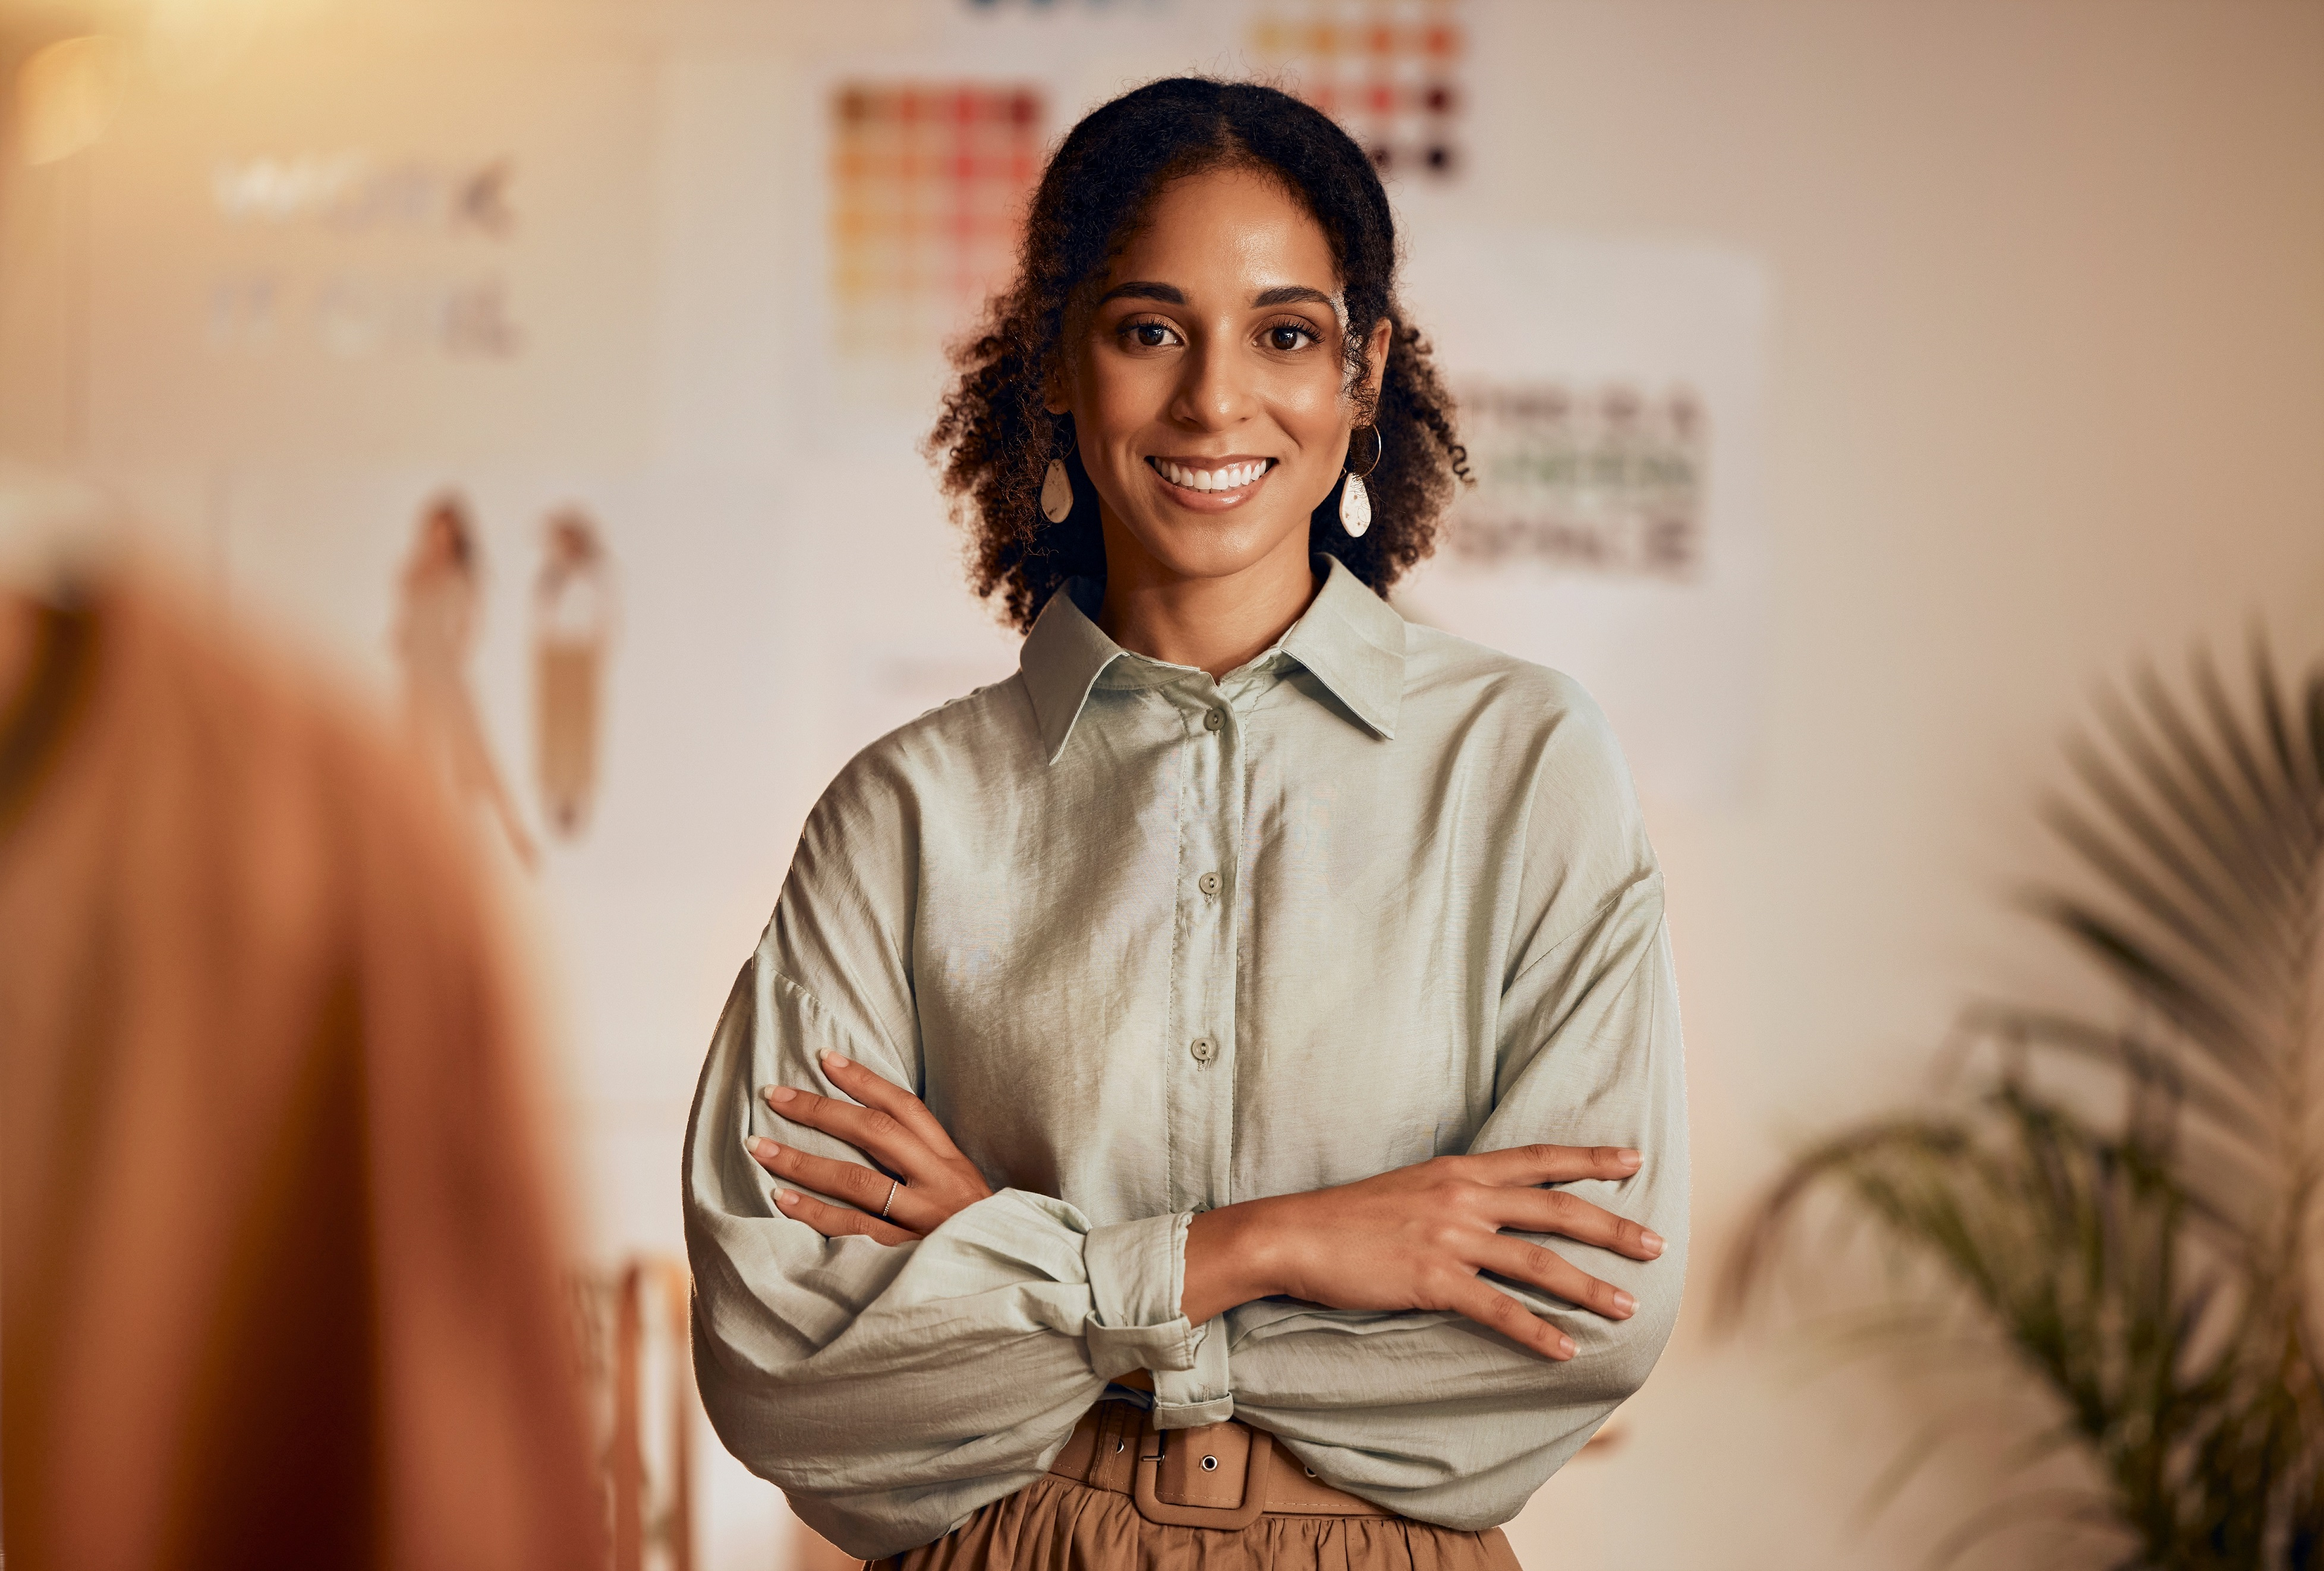

In [17]:
display_image(image, width=640, height=640)

In [18]:
get_multi_modal_completion (prompt, "", prefill, image)

Current Image Path: C:\Users\Administrator\Desktop\dev\jupyter\bedrock-anthropic\image\shutterstock_2235667567.jpg
================anthropic.claude-3-sonnet-20240229-v1:0===============

Human: Analyze the emotion and body language portrayed in this portrait photograph. 
What techniques did the photographer use to capture the subject's personality and evoke a particular mood?


Assistant:

This portrait photograph captures a woman with a warm, radiant smile and an open, friendly body language. Her arms are crossed, but in a relaxed manner that conveys confidence and approachability.

The photographer appears to have used soft, natural lighting that highlights the subject's glowing skin and brings out the warmth in her expression. The slightly blurred background puts the focus squarely on the woman, allowing her personality to take center stage.

The composition is well-balanced, with the subject positioned slightly off-center, creating a sense of dynamism and movement within the frame.

# Multimodal prompt with InvokeModelWthResponseStream

#### Lesson			
The following examples shows how to stream the response from Anthropic Claude Sonnet (on demand) for a multimodal request.

In [19]:
import botocore,time
import os
from pathlib import Path
import base64
accept = "application/json"
content_type = "application/json"

# Claude3
def get_multi_modal_stream_completion (prompt: str, system_prompt="", prefill ="", image=""):
    modelId_3 = model

    if image:

        # Get the current working directory
        cwd = os.getcwd()
        #print(f"Current Working Directory: {cwd}")
        
        # Get the current Jupyter Notebook file path
        image_path = cwd +"\\image\\"+image
        print(f"Current Image Path: {image_path}")      
        # Read reference image from file and encode as base64 strings.
        with open(image_path, "rb") as image_file:
            content_image = base64.b64encode(image_file.read()).decode('utf8')

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image", "source": {"type": "base64",
                        "media_type": "image/jpeg", "data": content_image}}
                    ]
            }
        ]

    if prefill:
        messages.append(
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": prefill,
                    }
                ],
            }
        )

    
    body_3 = json.dumps(
    	{
    		"messages": messages,
    		"anthropic_version": "bedrock-2023-05-31",
    		"max_tokens": 1000,
            "system": system_prompt,
    		"temperature": 0,
    		"top_p": 0.9,
    	}
    )
    
    time_sta = time.perf_counter()
    response_3 = bedrock_runtime.invoke_model_with_response_stream(
    	body=body_3, modelId=modelId_3, accept=accept, contentType=content_type
    )

    print("================" + model + "===============")
    pretty_print_conversation(messages)

    #check if it's the first chunk or not
    check = 0
    for event in response_3.get("body"):
        chunk = json.loads(event["chunk"]["bytes"])
        
        if chunk['type'] == 'message_delta':
            print(f"\nStop reason: {chunk['delta']['stop_reason']}")
            print(f"Stop sequence: {chunk['delta']['stop_sequence']}")
            print(f"Output tokens: {chunk['usage']['output_tokens']}")
        
        if chunk['type'] == 'content_block_delta':
            if chunk['delta']['type'] == 'text_delta':
                if check == 0:
                    print(colored(chunk['delta']['text'].strip(), "magenta"), end="")
                    check = 1
                elif check == 1:
                    print(colored(chunk['delta']['text'], "magenta"), end="")
    # text
    #print(response_body_3["content"][0]["text"])
    #print(response_3) 
    #print(response_body_3["content"])
    #messages.append (response_body_3)

    time_end = time.perf_counter()
    print(f"time = {round(time_end - time_sta, 2)} second")
    print("============================================================")

In [20]:
prompt = '''
Human: Analyze the emotion and body language portrayed in this portrait photograph. 
What techniques did the photographer use to capture the subject's personality and evoke a particular mood?
'''

In [21]:
prefill ="Assistant:"

In [22]:
image="shutterstock_2235667567.jpg"

Current Image Path: C:\Users\Administrator\Desktop\dev\jupyter\bedrock-anthropic\image\shutterstock_2235667567.jpg


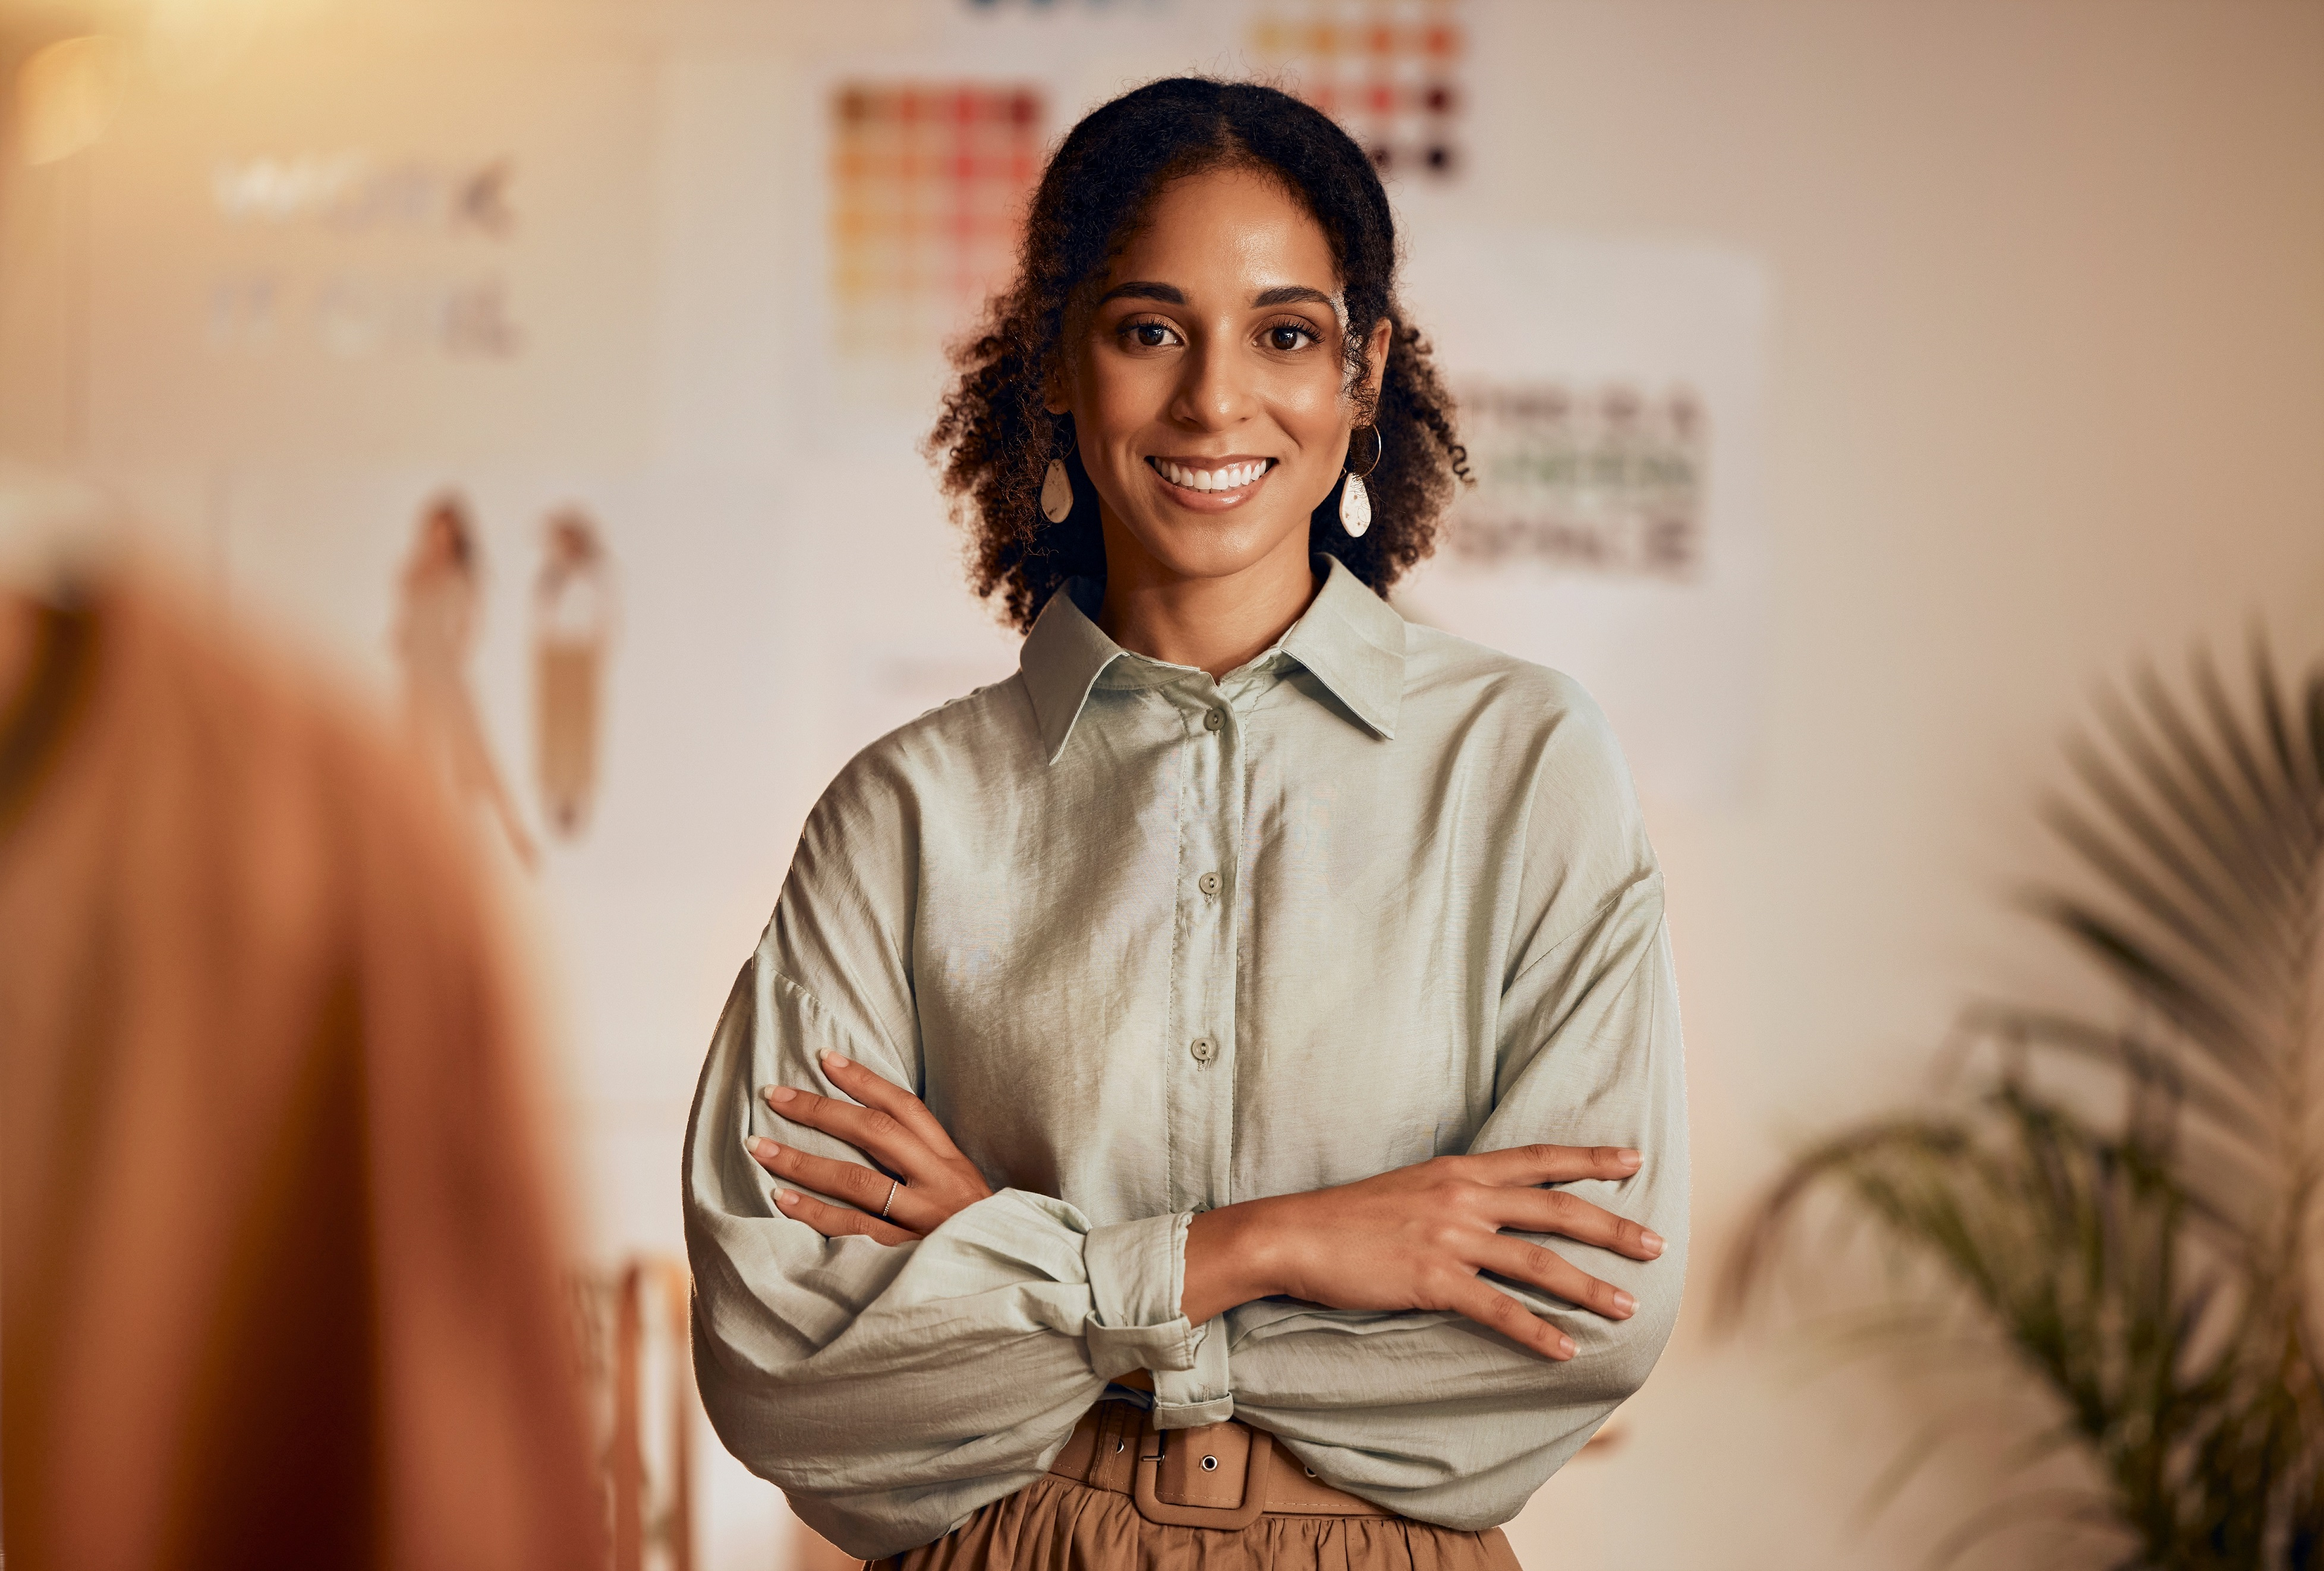

In [23]:
display_image(image, width=640, height=640)

In [24]:
get_multi_modal_stream_completion (prompt, "", prefill, image)

Current Image Path: C:\Users\Administrator\Desktop\dev\jupyter\bedrock-anthropic\image\shutterstock_2235667567.jpg
================anthropic.claude-3-sonnet-20240229-v1:0===============

Human: Analyze the emotion and body language portrayed in this portrait photograph. 
What techniques did the photographer use to capture the subject's personality and evoke a particular mood?


Assistant:

This portrait photograph captures a woman with a warm, radiant smile and an open, friendly body language. Her arms are crossed, but in a relaxed manner that conveys confidence and approachability. The photographer has used soft, natural lighting that highlights her joyful expression and brings out the warmth in her complexion.

The setting appears to be an artistic or creative workspace, with colorful artworks or sketches visible in the background. This environment complements the subject's stylish yet casual attire, suggesting a creative or artistic personality.

The photographer has framed the shot